# Сервис аренды самокатов GoFast

**Описание проекта**

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

**Без подписки** 
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

**С подпиской Ultra**
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи — users_go.csv**

- **user_id**	- уникальный идентификатор пользователя;
- **name** - имя пользователя
- **age**	- возраст
- **city** - город
- **subscription_type** - тип подписки (free, ultra)

**Поездки — rides_go.csv**

- **user_id** - уникальный идентификатор пользователя
- **distance** - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- **duration** - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- **date** -	дата совершения поездки

**Подписки — subscriptions_go.csv**
- **subscription_type** - тип подписки
- **minute_price** - стоимость одной минуты поездки по данной подписке
- **start_ride_price** - стоимость начала поездки
- **subscription_fee** - стоимость ежемесячного платежа

## **Загрузим и ознакомимся с данными**
### Выгрузим библиотеки

In [1]:
#Загрузим библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta
import time
import random
import warnings
warnings.filterwarnings("ignore")
import re
import ast
from scipy import stats as st

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Загрузим датасеты

In [2]:
#Загрузим датафрейм с пользователями
try:
    users_go = pd.read_csv('users_go.csv')
except:
    users_go = pd.read_csv('/datasets/users_go.csv')
display(users_go.head())
users_go.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [3]:
#Загрузим датафрейм с поездками
try:
    rides_go = pd.read_csv('rides_go.csv')
except:
    rides_go = pd.read_csv('/datasets/rides_go.csv')
display(rides_go.head())
rides_go.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [4]:
#Загрузим датафрейм с подписками
try:
    subscriptions_go = pd.read_csv('subscriptions_go.csv')
except:
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
display(subscriptions_go.head())
subscriptions_go.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


<div style="border:solid Blue 2px; padding: 20px">

**Вывод:** Загрузили и вывели информацию о датафреймах. Пропусков нет, но следует проверить на дубликаты и привести столбец "date" к правильному типу данных.

## **Предобработка данных**

### Столбец "date"

In [5]:
#Приведем столбец к правильному типу данных
rides_go['date'] = pd.to_datetime(rides_go['date'])

### Создадим новый столбец с номером месяца на основе столбца date

In [6]:
#Создадим новый столбец
rides_go['date_month'] = rides_go['date'].dt.month
#Проверим
rides_go

,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


### Проверим наличие пропущенных значений и дубликатов в датафреймах

#### Датафрейм "users_go"

In [7]:
#Проверим наличие пропущенных значений
print(users_go.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


In [8]:
#Проверим датафрейм на наличие дубликатов
print('В данных',users_go.duplicated().sum(), 'дубликат')

В данных 31 дубликат


In [9]:
#Ознакомимся с дубликатами
users_go[users_go.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [10]:
#Удалим дубликаты
users_go.drop_duplicates(inplace=True)
#Проверим
print('В данных',users_go.duplicated().sum(), 'дубликатов')

В данных 0 дубликатов


#### Датафрейм "rides_go"

In [11]:
#Проверим наличие пропущенных значений
print(rides_go.isna().sum())

user_id       0
distance      0
duration      0
date          0
date_month    0
dtype: int64


In [12]:
#Проверим датафрейм на наличие дубликатов
print('В данных',rides_go.duplicated().sum(), 'дубликатов')

В данных 0 дубликатов


#### Датафрейм "subscriptions_go"

In [13]:
#Проверим наличие пропущенных значений
print(subscriptions_go.isna().sum())

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [14]:
#Проверим датафрейм на наличие дубликатов
print('В данных',subscriptions_go.duplicated().sum(), 'дубликатов')

В данных 0 дубликатов


<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
1. Привели столбец "date" к правильному типу
2. Создали новый столбец с номером месяца
3. Пропущенных значений не обнаружили
4. Избавились от дубликатов в "users_go"

## **Исследовательский анализ данных**

### Частота встречаемости городов

In [15]:
#Создадим датафрейм, куда загрузим данные о частоте
city_percent = users_go['city'].value_counts()
city_percent

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

In [16]:
#Переведем данные в проценты
city_percent['rate'] = round(users_go['city'].value_counts() / city_percent.sum(), 2) * 100
city_percent['rate']

city
Пятигорск         14.0
Екатеринбург      13.0
Ростов-на-Дону    13.0
Краснодар         13.0
Сочи              12.0
Омск              12.0
Тюмень            12.0
Москва            11.0
Name: count, dtype: float64

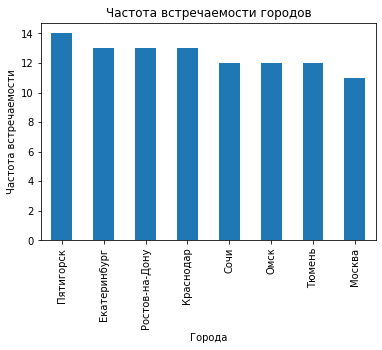

In [17]:
city_percent['rate'].plot(kind='bar')
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Частота встречаемости')
plt.show()

**Вывод:** Самым распространненым городом является Пятигорск, Москва же наоборот, встречается реже

### Cоотношение пользователей с подпиской и без подписки

In [18]:
#Создадим датафрейм с соотношением
subscription_status = users_go['subscription_type'].value_counts()
subscription_status

subscription_type
free     835
ultra    699
Name: count, dtype: int64

In [19]:
#Переведем данные в проценты
subscription_status['rate'] = round(users_go['subscription_type'].value_counts() / subscription_status.sum(), 2) * 100
subscription_status['rate']

subscription_type
free     54.0
ultra    46.0
Name: count, dtype: float64

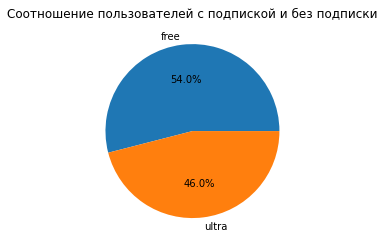

In [20]:
#Выведем график
plt.pie(subscription_status['rate'], labels=subscription_status['rate'].index, autopct='%1.1f%%')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()


**Вывод:** Пользователей с подпиской меньше(46%), чем без подписки(54%)

### Возраст пользователей

In [21]:
#Выведем возраст самого младшего пользователя
print('Самому младшему пользователю -',users_go['age'].sort_values().min())

Самому младшему пользователю - 12


In [22]:
#Выведем возраст самого старшего пользователя
print('Самому старшему пользователю -',users_go['age'].sort_values().max())

Самому старшему пользователю - 43


In [23]:
#Выведем средний возраст
print('Средний возраст -',users_go['age'].sort_values().median())

Средний возраст - 25.0


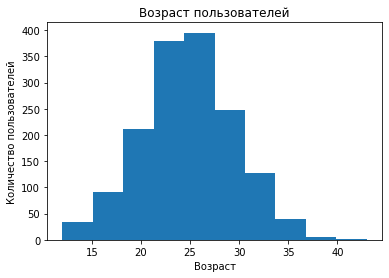

In [24]:
#Выведем график
users_go['age'].plot(kind='hist')
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

**Вывод:**
- Возраст младшего пользователя - 12
- Возраст старшего пользователя - 43
- Средний возраст - 25. В общем и целом же от 22 до 27 лет

### Расстояние, которое пользователь преодолел за одну поездку

In [25]:
#Выведем самую короткую поездку
print('Самая короткая поездка -',round(rides_go['distance'].sort_values().min(),2),'метра')

Самая короткая поездка - 0.86 метра


In [26]:
#Выведем самую длинную поездку
print('Самая длинная поездка -',round(rides_go['distance'].sort_values().max(),2),'метров')

Самая длинная поездка - 7211.01 метров


In [27]:
#Выведем среднее расстояние
print('Среднее расстояние -',round(rides_go['distance'].sort_values().mean(),2),'метров')

Среднее расстояние - 3070.66 метров


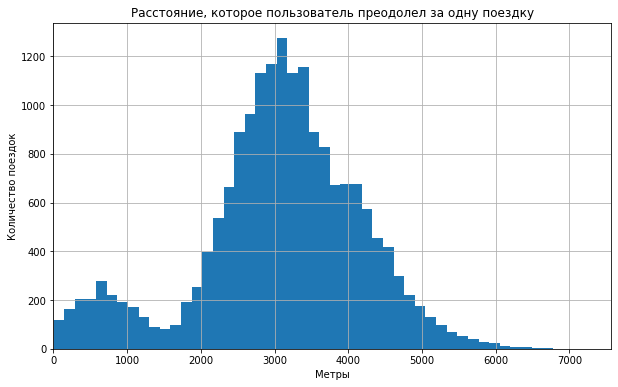

In [28]:
#Выведем график
ax = rides_go['distance'].plot(kind='hist', bins=50, figsize=(10,6), grid = True)
ax.set_title('Расстояние, которое пользователь преодолел за одну поездку')
ax.set_xlabel('Метры')
ax.set_ylabel('Количество поездок')
ax.set_xlim(left=0)
plt.show()

**Вывод:**
- Самая короткая поездка - 0.86 метра
- Самая длинная поездка - 7211.01 метров
- Среднее расстояние - 3070.66 метров

### Продолжительность поездок

In [29]:
#Выведем самую быструю поездку
print('Самая быстрая поездка -',rides_go['duration'].sort_values().min(),'минуты')

Самая быстрая поездка - 0.5 минуты


In [30]:
#Выведем самую долгую поездку
print('Самая долгая поездка -',round(rides_go['duration'].sort_values().max(),2),'минут')

Самая долгая поездка - 40.82 минут


In [31]:
#Выведем среднее время поездки
print('Среднее время поездки -',round(rides_go['duration'].sort_values().mean(),2),'минут')

Среднее время поездки - 17.81 минут


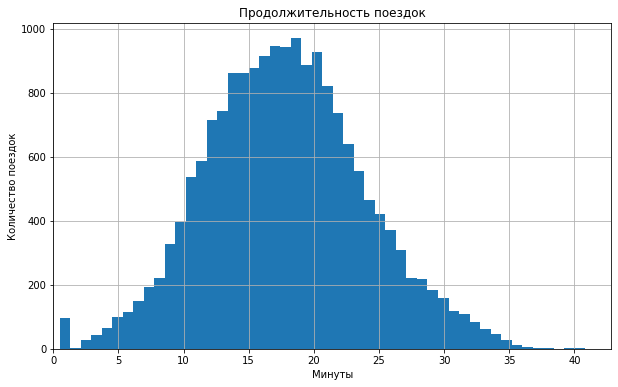

In [32]:
#Выведем график
ax = rides_go['duration'].plot(kind='hist', bins=50, figsize=(10,6), grid = True)
ax.set_title('Продолжительность поездок')
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество поездок')
ax.set_xlim(left=0)
plt.show()

**Вывод:**
- Самая быстрая поездка - 0.5 минуты
- Самая долгая поездка - 40.82 минут
- Среднее время поездки - 17.81 минут. В общем и целом же от 15 до 21 минуты

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
  
**Частота встречаемости городов:**
- Самым часто встречающимся городом является Пятигорск - 14%, наименее же встречаемый город Москва - 11%. Могу предположить, что связано это с размерами городов: Москва намного больше Пятигорска и в большинстве случаев жители преподчитают пользоваться услугами такси, нежели самокатами.

**Соотношение пользователей с подпиской и без:**
- Пользователей с подпиской меньше(46%), чем без подписки(54%);

**Возраст пользователей:**
- Возраст младшего пользователя - 12;
- Возраст старшего пользователя - 43;
- Средний возраст - 25. В общем и целом же от 22 до 27 лет;

**Расстояние, которое пользователь преодолел за одну поездку:**
- Самая короткая поездка - 0.86 метра
- Самая длинная поездка - 7211.01 метров
- Среднее расстояние - 3070.66 метров

**Продолжительность поездок:**
- Самая быстрая поездка - 0.5 минуты. Тут есть несколько причин, почему так может быть: Пользователь взял самокат, необратив внимание на зарядку, либо же какая-то неисправность самого самоката(не работают тормоза и т.д.)
- Самая долгая поездка - 40.82 минут
- Среднее время поездки - 17.81 минут. В общем и целом же от 15 до 21 минуты

## **Объединение данных**

### Создадим общий датафрейм

In [33]:
#Объединяем данные
df = users_go.merge(rides_go)
df = df.merge(subscriptions_go)
df

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


### Создадим отдельные датафреймы для пользователей с подпиской и без

In [34]:
#Создадим датафрейм для пользователей без подписка
df_free = df[df['subscription_type'] == 'free']
df_free

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [35]:
#Создадим датафрейм для пользователей с подпиской
df_ultra = df[df['subscription_type'] == 'ultra']
df_ultra

,user_id,name,age,city,subscription_type,distance,duration,date,date_month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

#### Пользователи без подписки

In [36]:
#Выведем самую короткую поездку
print('Самая короткая поездка -',round(df_free['distance'].sort_values().min(),2),'метра')
#Выведем самую длинную поездку
print('Самая длинная поездка -',round(df_free['distance'].sort_values().max(),2),'метров')
#Выведем среднюю длину поездки
print('Средняя длина поездки -',round(df_free['distance'].sort_values().mean(),2),'метров')

Самая короткая поездка - 0.86 метра
Самая длинная поездка - 7211.01 метров
Средняя длина поездки - 3045.5 метров


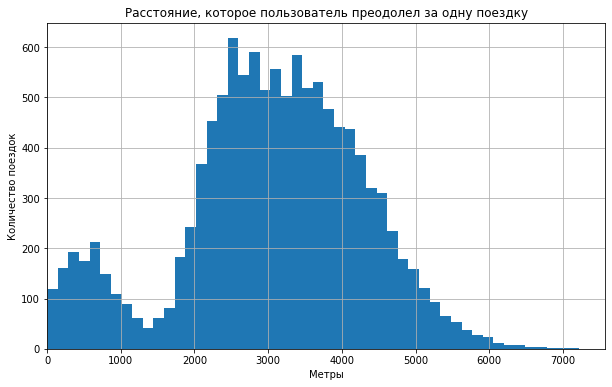

In [37]:
#Визуализируем информацию о расстоянии
ax = df_free['distance'].plot(kind='hist', bins=50, figsize=(10,6), grid = True)
ax.set_title('Расстояние, которое пользователь преодолел за одну поездку')
ax.set_xlabel('Метры')
ax.set_ylabel('Количество поездок')
ax.set_xlim(left=0)
plt.show()

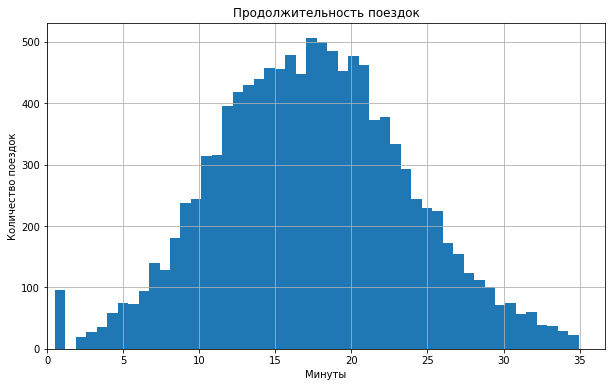

In [38]:
#Визуализируем информацию о времени поездок
ax = df_free['duration'].plot(kind='hist', bins=50, figsize=(10,6), grid = True)
ax.set_title('Продолжительность поездок')
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество поездок')
ax.set_xlim(left=0)
plt.show()

#### Пользователи с подпиской

In [39]:
#Выведем самую короткую поездку
print('Самая короткая поездка -',round(df_ultra['distance'].sort_values().min(),2),'метра')
#Выведем самую длинную поездку
print('Самая длинная поездка -',round(df_ultra['distance'].sort_values().max(),2),'метров')
#Выведем среднюю длину поездки
print('Средняя длина поездки -',round(df_ultra['distance'].sort_values().mean(),2),'метров')

Самая короткая поездка - 244.21 метра
Самая длинная поездка - 5699.77 метров
Средняя длина поездки - 3115.45 метров


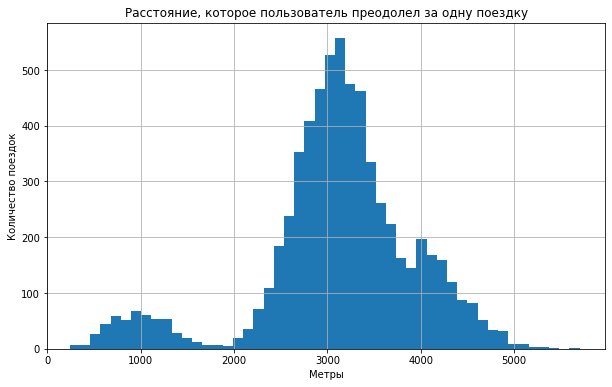

In [40]:
#Визуализируем информацию о расстоянии
ax = df_ultra['distance'].plot(kind='hist', bins=50, figsize=(10,6), grid = True)
ax.set_title('Расстояние, которое пользователь преодолел за одну поездку')
ax.set_xlabel('Метры')
ax.set_ylabel('Количество поездок')
ax.set_xlim(left=0)
plt.show()

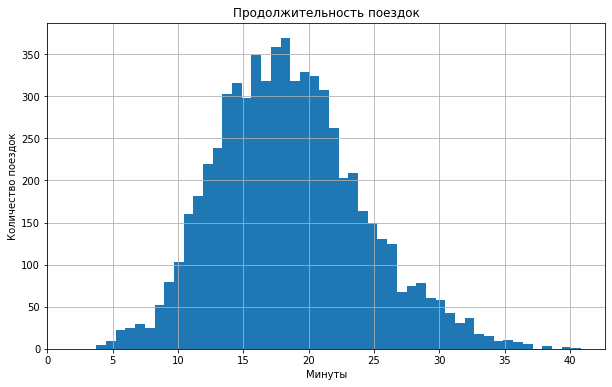

In [41]:
#Визуализируем информацию о времени поездок
ax = df_ultra['duration'].plot(kind='hist', bins=50, figsize=(10,6), grid = True)
ax.set_title('Продолжительность поездок')
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество поездок')
ax.set_xlim(left=0)
plt.show()

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
- Создали общий датафрейм - **df**
- Создали отдельные датафреймы для пользователей с подпиской - **df_ultra** и без подписки - **df_free**

**Пользователи без подписки:**
- Самая короткая поездка - 0.86 метра
- Самая длинная поездка - 7211.01 метров
- Средняя длина поездки - 3045.5 метров

**Пользователи с подпиской:**
- Самая короткая поездка - 244.21 метра
- Самая длинная поездка - 5699.77 метров
- Средняя длина поездки - 3115.45 метров

В общем и целом, можно заметить, что пользователи без подписки совершают длинные поездки чаще, чем пользователи с подпиской, однако средняя длина все же больше и пользователей с подпиской

## **Подсчет выручки**

### Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [42]:
#Округляем
df['duration'] = np.ceil(df['duration'])
#Создадим датафрейм с данными
df2 = pd.pivot_table(df,
                     index = ['user_id', 'date_month'],
                     values = ['distance', 'duration', 'name', 'subscription_type'],
                     aggfunc = {'distance': sum,
                               'name': len,
                               'duration': sum,
                               'subscription_type': min})

In [43]:
#Переименуем столбцы
df2.rename(columns = {'distance' : 'distance_sum', 
                      'name' : 'trips_count', 
                      'duration' : 'duration_sum'}, inplace = True)

In [44]:
#Округляем
#df2['duration_sum'] = np.ceil(df2['duration_sum'])

In [45]:
df2

distance_sum  duration_sum  trips_count subscription_type
user_id date_month                                                           
1       1            7027.511294          42.0            2             ultra
        4             754.159807           7.0            1             ultra
        8            6723.470560          46.0            2             ultra
        10           5809.911100          32.0            2             ultra
        11           7003.499363          56.0            3             ultra
...                          ...           ...          ...               ...
1534    6            3409.468534          26.0            2              free
        8            7622.453034          48.0            2              free
        9            4928.173852          23.0            1              free
        11          13350.015305          78.0            4              free
        12           2371.711192          16.0            1              free

[11331 rows x 4 columns]

### Добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [46]:
#Создадим функцию
def revenue(rev):
    if rev['subscription_type'] == 'free':
        return 8 * rev['duration_sum'] + 50 * rev['trips_count']
    else:
        return 6 * rev['duration_sum'] + 199

In [47]:
#Добавим столбец в датафрейм
df2['monthly_revenue'] = df2.apply(revenue, axis=1)
df2['monthly_revenue'].head(20)

user_id  date_month
1        1             451.0
         4             241.0
         8             475.0
         10            391.0
         11            535.0
         12            367.0
2        3             577.0
         4             439.0
         6             283.0
         7             487.0
         8             241.0
         10            313.0
         12            271.0
3        1             277.0
         2             433.0
         4             325.0
         5             577.0
         7             601.0
         9             337.0
         12            277.0
Name: monthly_revenue, dtype: float64

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
- Создали новый датафрейм с суммарным расстояние, количеством поездок и суммарным временем для каждого пользователя за каждый месяц;
- Добавили в датафрейм столбец с помесячной выручкой, которую принес каждый пользователь.

## **Проверка гипотез**

### Тратят ли пользователи с подпиской больше времени на поездки?

**Гипотеза:**

**H_0:** Время на поездки пользователей Ultra = Время на поездки пользователей Free

**H_1:** Время на поездки пользователей Ultra > Время на поездки пользователей Free

In [48]:
#Проверим гипотезу
alpha = 0.05 #указываем уровень статистической значимости
results = st.ttest_ind(df_ultra['duration'],
                       df_free['duration'],
                       alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


<function matplotlib.pyplot.show(close=None, block=None)>

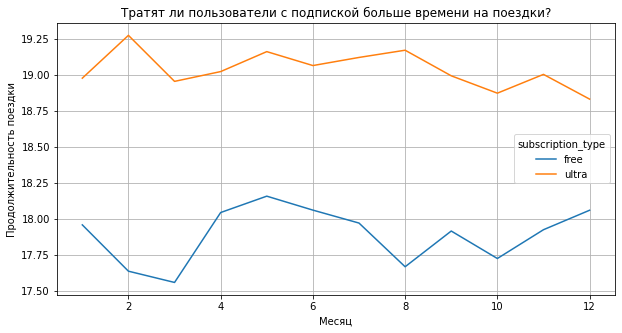

In [49]:
#Посмотрим на графике
(
    df
    .pivot_table(index = 'date_month', values = 'duration', columns = 'subscription_type')
    .plot(title = 'Тратят ли пользователи с подпиской больше времени на поездки?', kind = 'line', grid = True, figsize = (10,5))
)
plt.xlabel('Месяц')
plt.ylabel('Продолжительность поездки')
plt.show

**Вывод:** Да, пользователи с подпиской тратят больше времени на поездки

### Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

**Гипотеза:**

**H_0:** Среднее расстояние пользователей с подпиской за одную поездку = 3130

**H_1:** Среднее расстояние пользователей с подпиской за одную поездку > 3130

In [50]:
#Проверим гипотезу

interested_value = 3130

alpha = 0.05

results = st.ttest_1samp(df_ultra['distance'],
                         interested_value,
                         alternative = 'greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


<function matplotlib.pyplot.show(close=None, block=None)>

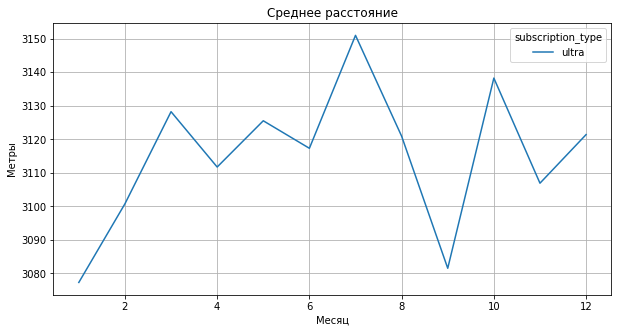

In [51]:
#Посмотрим на графике
(
    df_ultra
    .pivot_table(index = 'date_month', values = 'distance', columns = 'subscription_type')
    .plot(title = 'Среднее расстояние', kind = 'line', grid = True, figsize = (10,5))
)
plt.xlabel('Месяц')
plt.ylabel('Метры')
plt.show

**Вывод:** Можно, ведь не получилось отвергнуть нулевую гипотезу

###  Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

In [52]:
#Создадим отдельные переменные для пользователей с подпиской и без
ultra_month = df2.loc[df2.subscription_type == 'ultra', 'monthly_revenue']
free_month = df2.loc[df2.subscription_type == 'free', 'monthly_revenue']

In [53]:
#Проверим гипотезу
#H_0: выручка ultra = выручка free
#H_1: выручка ultra > выручка free

alpha = 0.05 #указываем уровень статистической значимости

results = st.ttest_ind(ultra_month,
                       free_month,
                       alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод:** Да, помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

### Какой тест вам понадобился бы для проверки этой гипотезы?

**Вывод:** В данном случае более правильным будет использовать гипотезу о равенстве средних для зависимых выборок, где:
- H_0: обращения до обновления = обращения после обновления
- H_1: обращения до обновления > обращения после обновления
- Будем использовать метод scipy.stats.ttest_rel()

<div style="border:solid Blue 2px; padding: 20px">

**Вывод:**
1. **Тратят ли пользователи с подпиской больше времени на поездки?** - Да, пользователи с подпиской тратят больше времени на поездки;
2. **Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?** - Можно, ведь не получилось отвергнуть нулевую гипотезу;
3. **Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?** - Да, помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки
4. **Какой тест вам понадобился бы для проверки этой гипотезы?** - В данном случае более правильным будет использовать гипотезу о равенстве средних для зависимых выборок, где: 
- H_0: обращения до обновления = обращения после обновления
- H_1: обращения до обновления > обращения после обновления
- Будем использовать метод scipy.stats.ttest_rel()

## **Общий вывод**

<div style="border:solid Blue 2px; padding: 20px">

**1. Загрузили и ознакомились с данными, а также провели предобработку данных:**
- Привели столбец "date" к правильному типу
- Создали новый столбец с номером месяца
- Пропущенных значений не обнаружили
- Избавились от дубликатов в "users_go"

**2. Провели исследовательский анализ данных:**

**Частота встречаемости городов:**
- Самым часто встречающимся городом является Пятигорск - 14%, наименее же встречаемый город Москва - 11%. Могу предположить, что связано это с размерами городов: Москва намного больше Пятигорска и в большинстве случаев жители преподчитают пользоваться услугами такси, нежели самокатами.

**Соотношение пользователей с подпиской и без:**
- Пользователей с подпиской меньше(46%), чем без подписки(54%);

**Возраст пользователей:**
- Возраст младшего пользователя - 12;
- Возраст старшего пользователя - 43;
- Средний возраст - 25. В общем и целом же от 22 до 27 лет;

**Расстояние, которое пользователь преодолел за одну поездку:**
- Самая короткая поездка - 0.86 метра
- Самая длинная поездка - 7211.01 метров
- Среднее расстояние - 3070.66 метров

**Продолжительность поездок:**
- Самая быстрая поездка - 0.5 минуты. Тут есть несколько причин, почему так может быть: Пользователь взял самокат, необратив внимание на зарядку, либо же какая-то неисправность самого самоката(не работают тормоза и т.д.)
- Самая долгая поездка - 40.82 минут
- Среднее время поездки - 17.81 минут. В общем и целом же от 15 до 21 минуты

**3. Объединили данные и визуализировали информацию:**

- Создали общий датафрейм - **df**
- Создали отдельные датафреймы для пользователей с подпиской - **df_ultra** и без подписки - **df_free**

**Пользователи без подписки:**
- Самая короткая поездка - 0.86 метра
- Самая длинная поездка - 7211.01 метров
- Средняя длина поездки - 3045.5 метров

**Пользователи с подпиской:**
- Самая короткая поездка - 244.21 метра
- Самая длинная поездка - 5699.77 метров
- Средняя длина поездки - 3115.45 метров

В общем и целом, можно заметить, что пользователи без подписки совершают длинные поездки чаще, чем пользователи с подпиской, однако средняя длина все же больше и пользователей с подпиской

**4. Подсчитали выручку:**

- Создали новый датафрейм с суммарным расстояние, количеством поездок и суммарным временем для каждого пользователя за каждый месяц;
- Добавили в датафрейм столбец с помесячной выручкой, которую принес каждый пользователь.

**5. Проверили гипотезы:**

1. **Тратят ли пользователи с подпиской больше времени на поездки?** - Да, пользователи с подпиской тратят больше времени на поездки;
2. **Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?** - Можно, ведь не полуичлось отвергнуть нулевую гипотезу;
3. **Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?** - Да, помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки
4. **Какой тест вам понадобился бы для проверки этой гипотезы?** - В данном случае более правильным будет использовать гипотезу о равенстве средних для зависимых выборок, где: 
- H_0: обращения до обновления = обращения после обновления
- H_1: обращения до обновления > обращения после обновления
- Будем использовать метод scipy.stats.ttest_rel()
    